In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
FS = 128

In [3]:
# Open the MAXM86161 file
def opencsv(name):
    with open(name) as fp:
        skip = next(filter(
            lambda x: x[1].startswith('timestamp'),
            enumerate(fp)
        ))[0]
    df = pd.read_csv(name, skiprows=skip)
    df.drop(df.tail(4).index,
            inplace = True)
    df['timestamp']=df['timestamp'].astype(float).astype(int)
    return df

In [4]:
df_ppg = opencsv('finger_1000.csv')[8000:20800]
df_ppg.reset_index(drop=True, inplace=True)

/var/folders/db/jd5sxcv14dx66ylxdf8scbsc0000gn/T/ipykernel_74736/3310715477.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(name, skiprows=skip)


In [5]:
df_ppg

,timestamp,sampleNum,tagLEDC1,tagLEDC2,tagLEDC3,LEDC1,LEDC2,LEDC3,ACCX,ACCY,ACCZ,temperature,RTC,sensor,regAddr,val,I2Caddr,Unnamed: 17
0,1704702647464,8001.0,0.0,0.0,0.0,305913.0,89063.0,122550.0,-910.0,-114.0,131.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1704702647472,8002.0,0.0,0.0,0.0,305927.0,89066.0,122605.0,-936.0,-102.0,185.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1704702647480,8003.0,0.0,0.0,0.0,305958.0,89061.0,122548.0,-947.0,-99.0,168.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1704702647488,8004.0,0.0,0.0,0.0,306011.0,88993.0,122547.0,-953.0,-98.0,138.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1704702647495,8005.0,0.0,0.0,0.0,306006.0,88925.0,122521.0,-982.0,-82.0,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12795,1704702747351,20796.0,0.0,0.0,0.0,301653.0,86995.0,121648.0,-997.0,-34.0,79.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12796,1704702747359,20797.0,0.0,0.0,0.0,301698.0,87042.0,121673.0,-1006.0,-26.0,67.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12797,1704702747367,20798.0,0.0,0.0,0.0,301759.0,87065.0,121654.0,-1014.0,-31.0,69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12798,1704702747375,20799.0,0.0,0.0,0.0,301907.0,87069.0,121703.0,-1017.0,-36.0,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_ppg['timestamp'] -= min(df_ppg['timestamp'])
df_ppg['timestamp'] //= 1000

The signal is upside-down

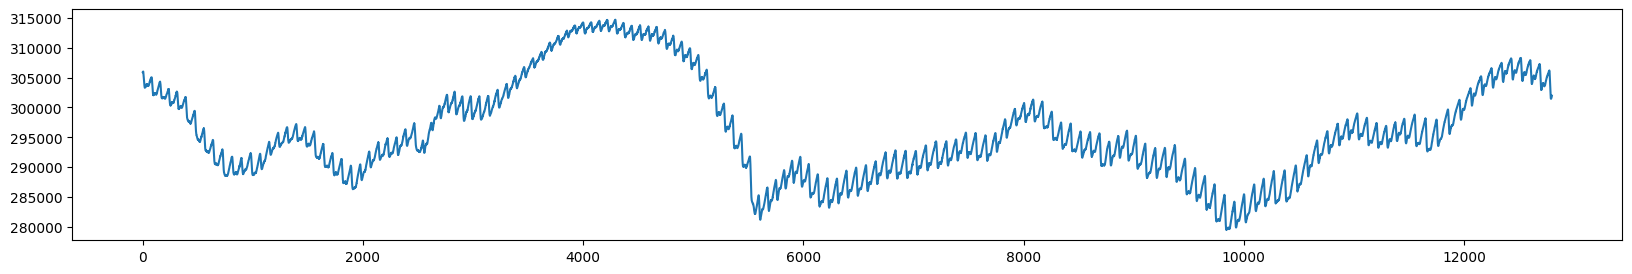

In [7]:
plt.figure(figsize=(20, 3))
plt.plot(df_ppg['LEDC1'])
plt.show()

It is a bit noisy

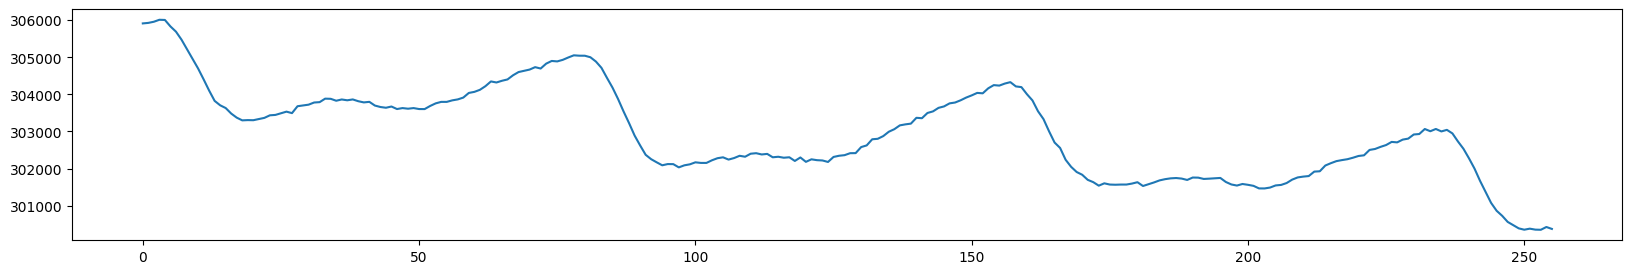

In [8]:
plt.figure(figsize=(20, 3))
plt.plot(df_ppg['LEDC1'][:256])
plt.show()

Lowpass filter to remove noise

MAXM86161 output is at 128Hz

In [9]:
# Butterworth lowpass filter
from scipy import signal

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, fs, cutoff, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [10]:
df_ppg['LEDC1_LPF_10Hz'] = butter_lowpass_filter(df_ppg['LEDC1'], FS, 10)

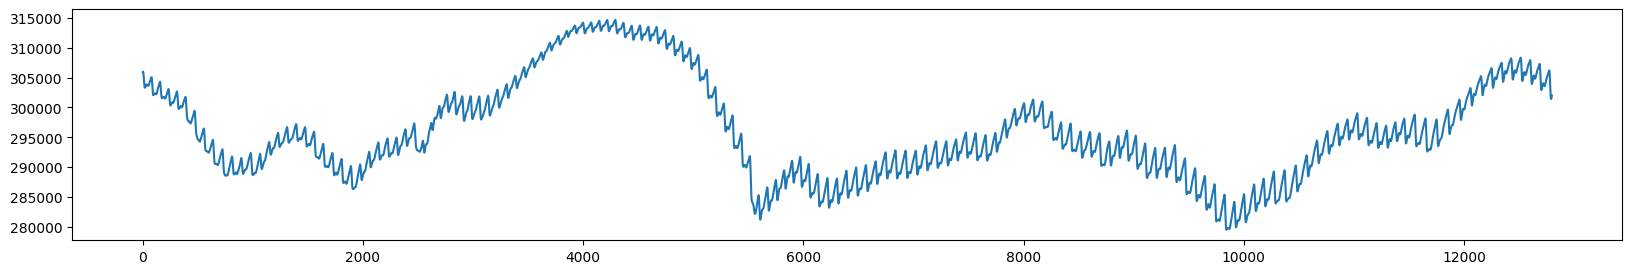

In [11]:
plt.figure(figsize=(20, 3))
plt.plot(df_ppg['LEDC1_LPF_10Hz'])
plt.show()

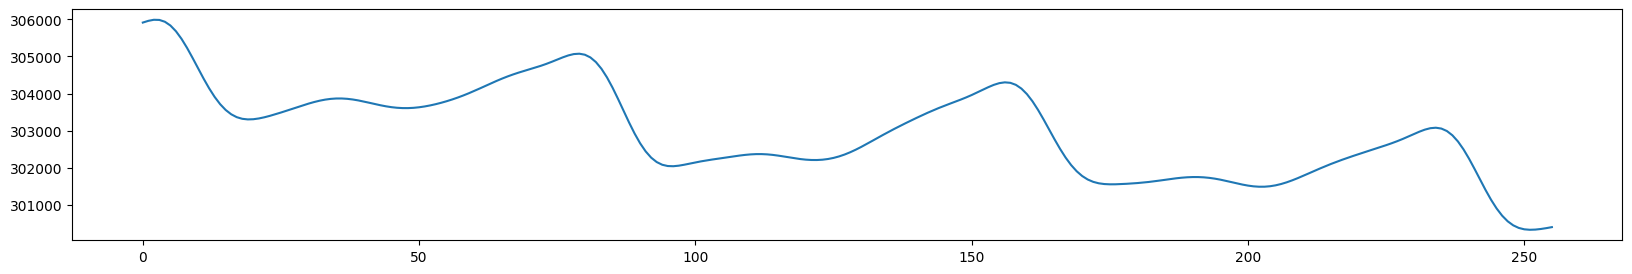

In [12]:
plt.figure(figsize=(20, 3))
plt.plot(df_ppg['LEDC1_LPF_10Hz'][:256])
plt.show()

Removing the DC component

In [13]:
# Bandpass filter
def butter_bandpass(cutoff_l, cutoff_h, fs, order=5):
    nyq = 0.5 * fs
    b, a = signal.butter(order, [cutoff_l/nyq, cutoff_h/nyq], btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, fs, cutoff_l, cutoff_h, order=5):
    b, a = butter_bandpass(cutoff_l, cutoff_h, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [14]:
from statistics import median

# Decide on prominence based on the approximate AC component
def get_prominence(p, fs):
    # Get the approximate AC component
    bpfed = butter_bandpass_filter(p, fs, 0.8, 3.5)
    bpfed -= min(bpfed)
    
    return median(bpfed)/2

In [15]:
# We assume heart beats should be longer than 0.4s. 
# Will have to change if subject is exercising
def peakfind_ppg(x, distance=0.4*FS):
    peaks, _ = signal.find_peaks(x, distance=distance, prominence=get_prominence(x, FS))
    return peaks

We will fit a cubic spline through the peaks in the upside-down signal (feet)

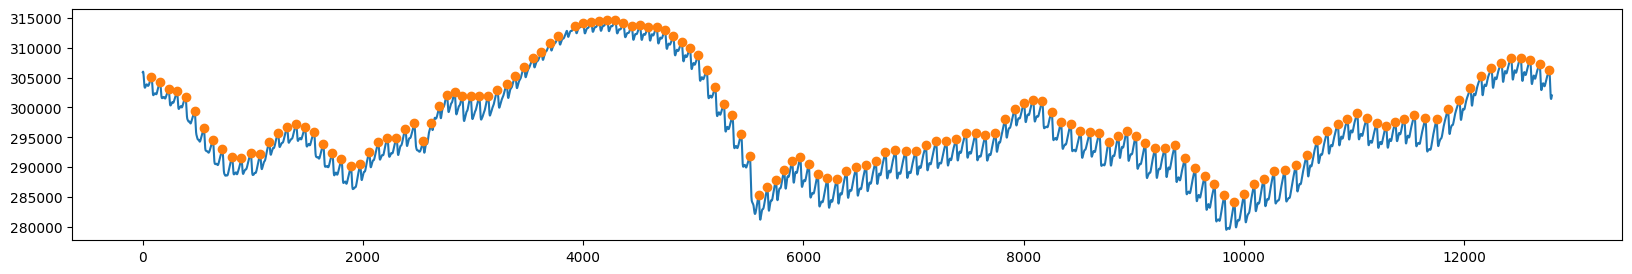

In [16]:
plt.figure(figsize=(20, 3))
peaks = peakfind_ppg(df_ppg['LEDC1_LPF_10Hz'].values)
plt.plot(df_ppg['LEDC1_LPF_10Hz'].values)
plt.plot(peaks, df_ppg['LEDC1_LPF_10Hz'].values[peaks], 'o')
plt.show()

In [17]:
from scipy import interpolate

def minus_cubic(p):
    peaks = peakfind_ppg(p)
    
    x = np.arange(0, len(p) / FS, 1/FS)
    line = interpolate.CubicSpline(x[peaks], p[peaks])
    
    return p - line(x)

In [18]:
# * -1 to flip the signal
df_ppg['LEDC1_AC'] = minus_cubic(df_ppg['LEDC1_LPF_10Hz']) * -1

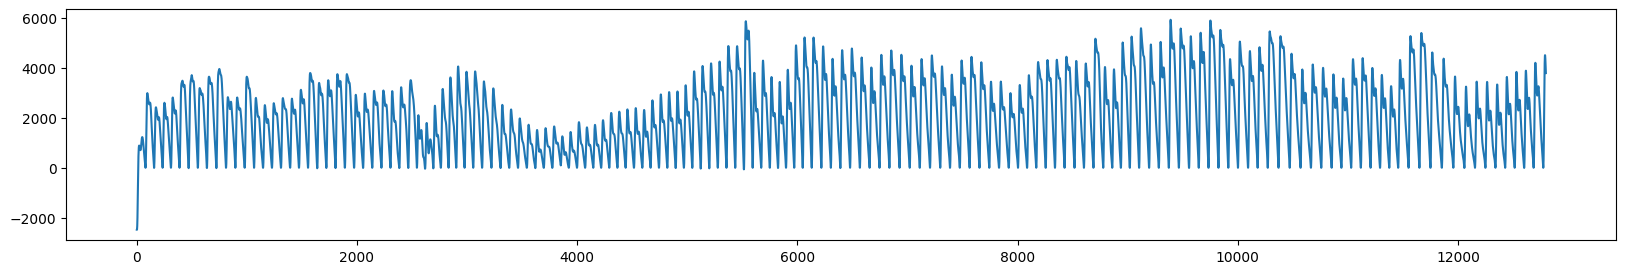

In [19]:
plt.figure(figsize=(20, 3))
plt.plot(df_ppg['LEDC1_AC'])
plt.show()

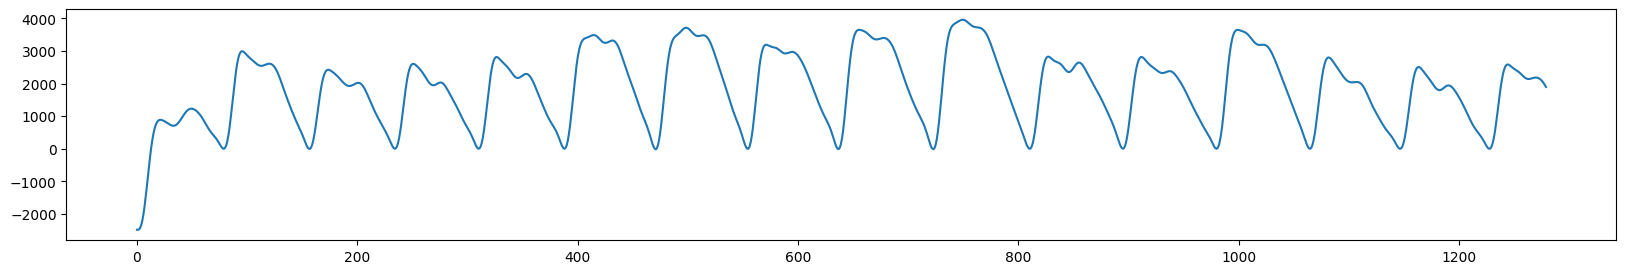

In [20]:
plt.figure(figsize=(20, 3))
plt.plot(df_ppg['LEDC1_AC'][:1280])
plt.show()

Comparison with bandpass filter. Note that the baseline is not consistent and waveform features are less obvious. Frequency domain filtering can affect the fine grained features in PPG waveforms. 

However, this method is more suitable for cases with motion, since it does not require any peak detection.

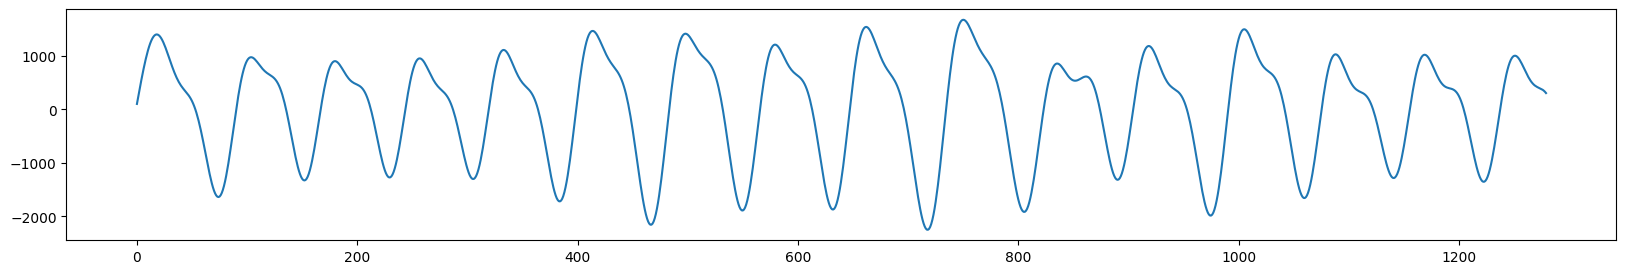

In [21]:
df_ppg['LEDC1_BPF'] = butter_bandpass_filter(df_ppg['LEDC1_LPF_10Hz'], FS, 0.8, 3.5) * -1
plt.figure(figsize=(20, 3))
plt.plot(df_ppg['LEDC1_BPF'][:1280])
plt.show()

Example of signal with motion processed with cubic spline removal. Motion tends to make peak detection fail, so cubic spline fails. 

Waveforms that go below or float above the baseline should not be considered

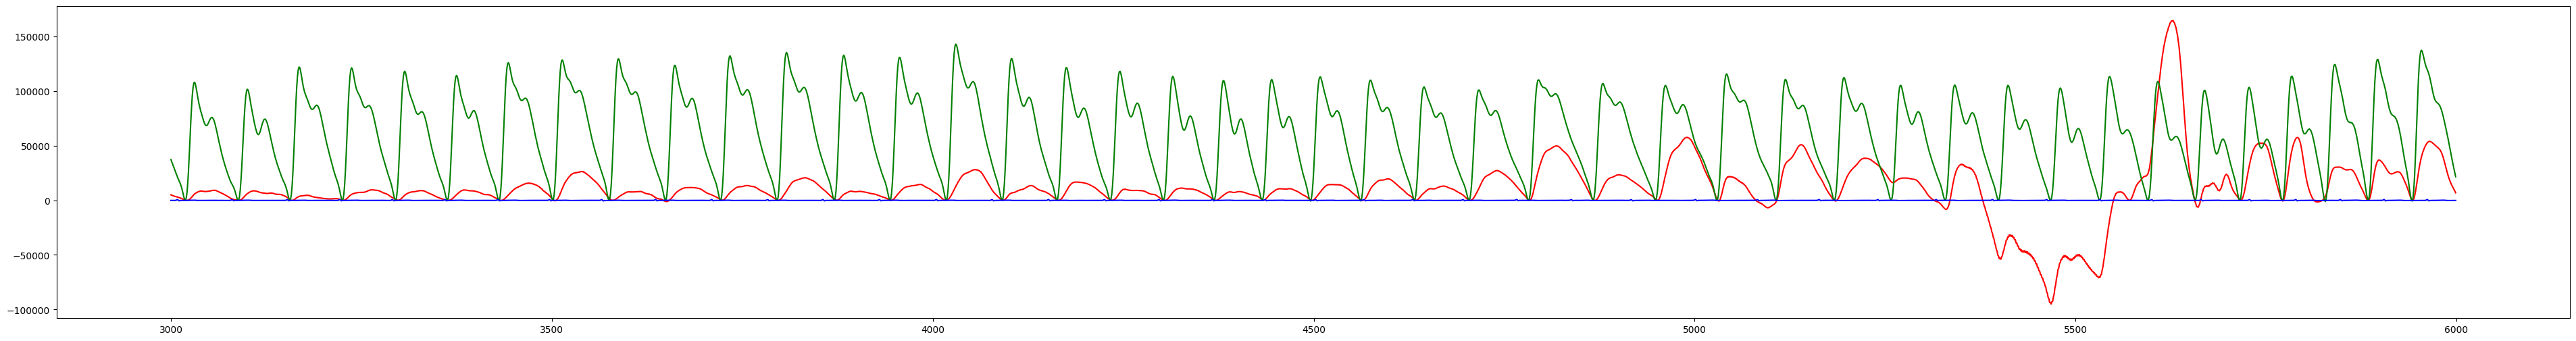

In [22]:
df = pd.read_csv('6_preprocessed_1028.csv')[3000:6000]

plt.figure(figsize=(48,6))
plt.plot(df['PPG_In_AC']*25, color='r')
plt.plot(df['PPG_Ref_AC']*10, color='g')
plt.plot(df['ECG']*1000, color='blue')

plt.show()